In [ ]:
%cd drive/MyDrive/projects/toxicity-multiclass
!ls

/content/drive/MyDrive/projects/toxicity-multiclass
chapters  models     pyproject.toml  results  src
data	  notebooks  README.md	     scripts


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q transformers torch datasets accelerate scikit-learn

import sys
import os

sys.path.insert(0, '.')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import AutoTokenizer
import time
import json
from pathlib import Path

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f" Using device: {device}")
if device == 'cuda':
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("     No GPU detected ")

 Using device: cuda
   GPU: Tesla T4
   Memory: 15.8 GB


In [ ]:
# Model configuration
MODEL_NAME = "DeepChem/ChemBERTa-77M-MLM"
MAX_LENGTH = 128
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
USE_CLASS_WEIGHTING = True
NUM_EPOCHS = 40
EARLY_STOPPING_PATIENCE = 3
FREEZE_ENCODER = False

# Task configuration
TOX21_ASSAYS = [
    "NR-AR", "NR-AR-LBD", "NR-AhR", "NR-Aromatase",
    "NR-ER", "NR-ER-LBD", "NR-PPAR-gamma", "SR-ARE",
    "SR-ATAD5", "SR-HSE", "SR-MMP", "SR-p53"
]

print("Configuration:")
print(f"  Model: {MODEL_NAME}")
print(f"  Max length: {MAX_LENGTH}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Freeze encoder: {FREEZE_ENCODER} {'freeze' if FREEZE_ENCODER else 'not freeze'}")
print(f"  Device: {device}")

Configuration:
  Model: DeepChem/ChemBERTa-77M-MLM
  Max length: 128
  Batch size: 32
  Learning rate: 0.0001
  Epochs: 40
  Freeze encoder: False not freeze
  Device: cuda


In [ ]:
print(" Loading data...\n")

# Load cleaned DataFrames
train_df = pd.read_csv('data/processed/train_clean.csv')
val_df = pd.read_csv('data/processed/val_clean.csv')
test_df = pd.read_csv('data/processed/test_clean.csv')

print(f" Data loaded:")
print(f"   Train: {len(train_df):,} molecules")
print(f"   Val:   {len(val_df):,} molecules")
print(f"   Test:  {len(test_df):,} molecules")

# Show class distribution
print(f"\n Class distribution (train set):")
for assay in TOX21_ASSAYS:
    valid = train_df[assay].notna()
    if valid.sum() > 0:
        pos_rate = train_df.loc[valid, assay].mean()
        print(f"   {assay:<20} {pos_rate*100:5.1f}% toxic")

 Loading data...

 Data loaded:
   Train: 6,162 molecules
   Val:   777 molecules
   Test:  778 molecules

 Class distribution (train set):
   NR-AR                  4.5% toxic
   NR-AR-LBD              3.6% toxic
   NR-AhR                11.8% toxic
   NR-Aromatase           4.9% toxic
   NR-ER                 12.4% toxic
   NR-ER-LBD              4.7% toxic
   NR-PPAR-gamma          2.7% toxic
   SR-ARE                16.0% toxic
   SR-ATAD5               3.5% toxic
   SR-HSE                 5.7% toxic
   SR-MMP                15.3% toxic
   SR-p53                 6.2% toxic


In [ ]:
print(f" Loading tokenizer: {MODEL_NAME}\n")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print(f" Tokenizer loaded:")
print(f"   Vocabulary size: {len(tokenizer):,}")
print(f"   Max length: {MAX_LENGTH}")
print(f"   Special tokens: [CLS]={tokenizer.cls_token_id}, [SEP]={tokenizer.sep_token_id}, [PAD]={tokenizer.pad_token_id}")

# Test tokenization
test_smiles = train_df.iloc[0]['smiles']
encoded = tokenizer(test_smiles, max_length=MAX_LENGTH, padding='max_length', truncation=True)

print(f"\n Example tokenization:")
print(f"   SMILES: {test_smiles}")
print(f"   Tokens: {tokenizer.convert_ids_to_tokens(encoded['input_ids'][:20])}")
print(f"   Length: {sum(encoded['attention_mask'])} tokens")

 Loading tokenizer: DeepChem/ChemBERTa-77M-MLM



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


 Tokenizer loaded:
   Vocabulary size: 593
   Max length: 128
   Special tokens: [CLS]=12, [SEP]=13, [PAD]=0

 Example tokenization:
   SMILES: NCC(=O)O
   Tokens: ['[CLS]', 'N', 'C', 'C', '(', '=', 'O', ')', 'O', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
   Length: 10 tokens


In [ ]:
# Import your dataset class
from src.toxicity.data.chemberta_dataset import Tox21ChemBERTaDataset, create_dataloaders

print("Creating datasets...\n")

train_loader, val_loader, test_loader = create_dataloaders(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    tokenizer=tokenizer,
    smiles_col='smiles',
    task_cols=TOX21_ASSAYS,
    max_length=MAX_LENGTH,
    batch_size=BATCH_SIZE,
    num_workers=0
)

print(f" DataLoaders created:")
print(f"   Train: {len(train_loader)} batches")
print(f"   Val:   {len(val_loader)} batches")
print(f"   Test:  {len(test_loader)} batches")

Creating datasets...

 DataLoaders created:
   Train: 193 batches
   Val:   25 batches
   Test:  25 batches


In [ ]:
from src.toxicity.models.chemberta_multilabel import ChemBERTaMultiLabel ,compute_pos_weights



pos_weights = compute_pos_weights(
    train_df,
    TOX21_ASSAYS,
    method="balanced"  # weight = n_negative / n_positive
)

In [ ]:

print(" Initializing ChemBERTa model...\n")

model = ChemBERTaMultiLabel(
    model_name=MODEL_NAME,
    n_tasks=len(TOX21_ASSAYS),
    dropout=0.2,
    pooling="cls",
    freeze_encoder=True,
    pos_weight=pos_weights,
    use_mlp_head=True,
    label_smoothing=0.0
).to(device)

# Freeze everything then unfreeze last 2 layers
model.unfreeze_last_n_layers(n=2)



# Count parameters
from src.toxicity.training.chemberta_training import count_parameters, print_model_info

print_model_info(model)

params = count_parameters(model)
print(f"\n Training strategy:")
if FREEZE_ENCODER:
    print(f"   Encoder FROZEN (feature extraction)")
    print(f"   Head TRAINABLE ({params['trainable']:,} params)")
else:
    print(f"    Full/partial model TRAINABLE ({params['trainable']:,} params)")

 Initializing ChemBERTa model...



Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MODEL INFORMATION
Total parameters:     3,579,900
Trainable parameters: 2,052,652 (57.3%)
Frozen parameters:    1,527,248

 Training strategy:
    Full/partial model TRAINABLE (2,052,652 params)
    Expected: slower, slightly better performance


In [ ]:
print(" Testing forward pass...\n")

model.eval()
batch = next(iter(train_loader))

with torch.no_grad():
    test_batch = {
        'input_ids': batch['input_ids'][:2].to(device),
        'attention_mask': batch['attention_mask'][:2].to(device),
        'labels': batch['labels'][:2].to(device),
        'label_mask': batch['label_mask'][:2].to(device)
    }

    output = model(**test_batch)

print(f" Forward pass successful:")
print(f"   Loss: {output['loss'].item():.4f}")
print(f"   Logits shape: {output['logits'].shape}")
print(f"   Probabilities shape: {output['probabilities'].shape}")
print(f"\n   Example probabilities:")
print(f"   {output['probabilities'][0].cpu().numpy()}")

 Testing forward pass...

 Forward pass successful:
   Loss: 0.6843
   Logits shape: torch.Size([2, 12])
   Probabilities shape: torch.Size([2, 12])

   Example probabilities:
   [0.5013765  0.49147764 0.48146567 0.49339634 0.48620906 0.5059062
 0.49412546 0.49961394 0.47501332 0.49560657 0.4861685  0.5007225 ]


In [ ]:
# Import trainer
from src.toxicity.training.chemberta_training import ChemBERTaTrainer

print("Initializing trainer...\n")

trainer = ChemBERTaTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    learning_rate=1e-4,
    weight_decay=0.01,
    output_dir="models/chemberta_frozen",
    threshold=0.5,
    use_amp=True
    )

print(" Trainer initialized")
print(f"   Learning rate: {LEARNING_RATE}")
print(f"   Output directory: models/chemberta_frozen")
print(f"   Early stopping patience: {EARLY_STOPPING_PATIENCE}")

Initializing trainer...

 Trainer initialized
   Learning rate: 0.0001
   Output directory: models/chemberta_frozen
   Early stopping patience: 3


In [ ]:
# Train
print("\n" + "="*80)
print("STARTING TRAINING")
print("="*80)

start_time = time.time()

trainer.train(
    num_epochs=NUM_EPOCHS,
    early_stopping_patience=EARLY_STOPPING_PATIENCE,
    task_names=TOX21_ASSAYS
)

total_time = time.time() - start_time

print("\n" + "="*80)
print("TRAINING COMPLETE")
print("="*80)
print(f"Total time: {total_time:.0f}s ({total_time/60:.1f} min)")
print(f"Best validation F1: {trainer.best_val_f1:.4f}")
print("="*80)


STARTING TRAINING


Epoch 1/40 | train_loss=1.2016 | val_loss=1.2563 | val_macro_f1=0.2668 | lr(enc/head)=3.00e-05/1.00e-04
Saved checkpoint: models/chemberta_frozen/best_model.pt


Epoch 2/40 | train_loss=1.0939 | val_loss=1.1386 | val_macro_f1=0.2677 | lr(enc/head)=3.00e-05/1.00e-04
Saved checkpoint: models/chemberta_frozen/best_model.pt


Epoch 3/40 | train_loss=1.0122 | val_loss=1.1027 | val_macro_f1=0.2832 | lr(enc/head)=3.00e-05/1.00e-04
Saved checkpoint: models/chemberta_frozen/best_model.pt


Epoch 4/40 | train_loss=0.9653 | val_loss=1.0840 | val_macro_f1=0.2925 | lr(enc/head)=3.00e-05/1.00e-04
Saved checkpoint: models/chemberta_frozen/best_model.pt


Epoch 5/40 | train_loss=0.9346 | val_loss=1.0671 | val_macro_f1=0.3094 | lr(enc/head)=3.00e-05/1.00e-04
Saved checkpoint: models/chemberta_frozen/best_model.pt


Epoch 6/40 | train_loss=0.9106 | val_loss=1.0661 | val_macro_f1=0.3231 | lr(enc/head)=3.00e-05/1.00e-04
Saved checkpoint: models/chemberta_frozen/best_model.pt


Epoch 7/40 | train_loss=0.8909 | val_loss=1.0605 | val_macro_f1=0.3145 | lr(enc/head)=3.00e-05/1.00e-04


Epoch 8/40 | train_loss=0.8710 | val_loss=1.0488 | val_macro_f1=0.3246 | lr(enc/head)=3.00e-05/1.00e-04
Saved checkpoint: models/chemberta_frozen/best_model.pt


Epoch 9/40 | train_loss=0.8498 | val_loss=1.0688 | val_macro_f1=0.3393 | lr(enc/head)=3.00e-05/1.00e-04
Saved checkpoint: models/chemberta_frozen/best_model.pt


Epoch 10/40 | train_loss=0.8364 | val_loss=1.0582 | val_macro_f1=0.3344 | lr(enc/head)=3.00e-05/1.00e-04


Epoch 11/40 | train_loss=0.8272 | val_loss=1.0673 | val_macro_f1=0.3419 | lr(enc/head)=3.00e-05/1.00e-04
Saved checkpoint: models/chemberta_frozen/best_model.pt


Epoch 12/40 | train_loss=0.8064 | val_loss=1.0633 | val_macro_f1=0.3460 | lr(enc/head)=3.00e-05/1.00e-04
Saved checkpoint: models/chemberta_frozen/best_model.pt


Epoch 13/40 | train_loss=0.7884 | val_loss=1.0601 | val_macro_f1=0.3476 | lr(enc/head)=3.00e-05/1.00e-04
Saved checkpoint: models/chemberta_frozen/best_model.pt


Epoch 14/40 | train_loss=0.7788 | val_loss=1.0841 | val_macro_f1=0.3574 | lr(enc/head)=3.00e-05/1.00e-04
Saved checkpoint: models/chemberta_frozen/best_model.pt


Epoch 15/40 | train_loss=0.7740 | val_loss=1.0855 | val_macro_f1=0.3563 | lr(enc/head)=3.00e-05/1.00e-04


Epoch 16/40 | train_loss=0.7581 | val_loss=1.1105 | val_macro_f1=0.3744 | lr(enc/head)=3.00e-05/1.00e-04
Saved checkpoint: models/chemberta_frozen/best_model.pt


Epoch 17/40 | train_loss=0.7600 | val_loss=1.0786 | val_macro_f1=0.3582 | lr(enc/head)=3.00e-05/1.00e-04


Epoch 18/40 | train_loss=0.7406 | val_loss=1.0798 | val_macro_f1=0.3572 | lr(enc/head)=3.00e-05/1.00e-04


Epoch 19/40 | train_loss=0.7350 | val_loss=1.1169 | val_macro_f1=0.3741 | lr(enc/head)=1.50e-05/5.00e-05
Early stopping: no improvement for 3 epochs. Best val macro F1 = 0.3744
Saved training history: models/chemberta_frozen/training_history.json

TRAINING COMPLETE
Total time: 226s (3.8 min)
Best validation F1: 0.3744


In [ ]:
import numpy as np
import torch
from sklearn.metrics import f1_score

@torch.no_grad()
def collect_probs_labels_masks(model, loader, device):
    model.eval()
    probs_list, y_list, m_list = [], [], []
    for b in loader:
        out = model(
            input_ids=b["input_ids"].to(device),
            attention_mask=b["attention_mask"].to(device),
            labels=b["labels"].to(device),
            label_mask=b["label_mask"].to(device),
        )
        probs_list.append(out["probabilities"].detach().cpu().numpy())
        y_list.append(b["labels"].detach().cpu().numpy())
        m_list.append(b["label_mask"].detach().cpu().numpy().astype(bool))
    return np.concatenate(probs_list), np.concatenate(y_list), np.concatenate(m_list)

def masked_macro_f1(y_true, y_pred, mask):
    f1s = []
    for j in range(y_true.shape[1]):
        v = mask[:, j]
        if v.sum() == 0:
            continue
        f1s.append(f1_score(y_true[v, j], y_pred[v, j], zero_division=0))
    return float(np.mean(f1s)) if f1s else 0.0

# Collect VAL probabilities
val_probs, val_y, val_m = collect_probs_labels_masks(trainer.model, val_loader, device)

# Search best threshold
thresholds = np.linspace(0.05, 0.95, 19)
best_t, best_f1 = 0.5, -1
for t in thresholds:
    val_pred = (val_probs >= t).astype(int)
    mf1 = masked_macro_f1(val_y, val_pred, val_m)
    if mf1 > best_f1:
        best_f1, best_t = mf1, t

print("Best global threshold:", best_t)
print("Best VAL macro-F1:", best_f1)


Best global threshold: 0.7
Best VAL macro-F1: 0.4283075206676725


In [ ]:
# Load best model
print(" Loading best model...\n")
trainer.load_checkpoint('best_model.pt')

# Evaluate
print("Evaluating on test set...\n")
test_results = trainer.evaluate(test_loader, task_names=TOX21_ASSAYS)

# Print results
print("\n" + "="*80)
print("TEST RESULTS (Frozen Encoder)")
print("="*80)
print(f"\n Aggregate Metrics:")
print(f"   Macro F1:        {test_results['aggregate']['macro_f1']:.4f}")
print(f"   Macro Precision: {test_results['aggregate']['macro_precision']:.4f}")
print(f"   Macro Recall:    {test_results['aggregate']['macro_recall']:.4f}")
print(f"   Macro ROC-AUC:   {test_results['aggregate']['macro_roc_auc']:.4f}")

print(f"\n Per-Task F1 Scores:")
for task, metrics in test_results['per_task'].items():
    print(f"   {task:<20} {metrics['f1']:.4f}  ({metrics['n_positive']:>4} toxic / {metrics['n_samples']:>5} total)")

 Loading best model...

Loaded checkpoint: models/chemberta_frozen/best_model.pt
Evaluating on test set...




TEST RESULTS (Frozen Encoder)

 Aggregate Metrics:
   Macro F1:        0.3731
   Macro Precision: 0.2662
   Macro Recall:    0.6648
   Macro ROC-AUC:   0.8320

 Per-Task F1 Scores:
   NR-AR                0.2695  (  25 toxic /   724 total)
   NR-AR-LBD            0.4146  (  21 toxic /   667 total)
   NR-AhR               0.4476  (  73 toxic /   656 total)
   NR-Aromatase         0.3067  (  34 toxic /   571 total)
   NR-ER                0.4211  (  89 toxic /   621 total)
   NR-ER-LBD            0.3333  (  42 toxic /   689 total)
   NR-PPAR-gamma        0.2651  (  22 toxic /   636 total)
   SR-ARE               0.4534  (  84 toxic /   563 total)
   SR-ATAD5             0.3689  (  31 toxic /   699 total)
   SR-HSE               0.2716  (  35 toxic /   642 total)
   SR-MMP               0.5985  ( 106 toxic /   587 total)
   SR-p53               0.3268  (  41 toxic /   665 total)


In [ ]:
test_07 = trainer.evaluate(test_loader, task_names=TOX21_ASSAYS, threshold=0.7)
print("TEST macro-F1 0.7:", test_07["aggregate"]["macro_f1"])


TEST macro-F1 0.7: 0.4109338424161432


In [ ]:
test_05 = trainer.evaluate(test_loader, task_names=TOX21_ASSAYS, threshold=0.5)
print("TEST macro-F1 0.5:", test_05["aggregate"]["macro_f1"])


TEST macro-F1 0.5: 0.373098784738503


In [ ]:
import os
os.makedirs("models/chemberta_final", exist_ok=True)
os.makedirs("results/figures", exist_ok=True)

In [ ]:
test_probs, test_y, test_m = collect_probs_labels_masks(
    trainer.model, test_loader, device
)

test_pred = (test_probs >= best_t).astype(int)


In [ ]:
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np

per_task_metrics = {}

for i, task in enumerate(TOX21_ASSAYS):
    valid = test_m[:, i]
    if valid.sum() == 0:
        continue

    y_true = test_y[valid, i]
    y_pred = test_pred[valid, i]
    y_prob = test_probs[valid, i]

    per_task_metrics[task] = {
        "f1": float(f1_score(y_true, y_pred, zero_division=0)),
        "roc_auc": float(
            roc_auc_score(y_true, y_prob)
            if len(np.unique(y_true)) > 1 else np.nan
        ),
        "n_positive": int((y_true == 1).sum()),
        "n_samples": int(len(y_true))
    }


In [ ]:
macro_f1 = np.mean([m["f1"] for m in per_task_metrics.values()])
macro_roc_auc = np.nanmean([m["roc_auc"] for m in per_task_metrics.values()])


In [ ]:
import json

results_summary = {
    "model": "ChemBERTa Multi-Label Transformer",
    "best_threshold": float(best_t),
    "validation": {
        "macro_f1": float(trainer.best_val_f1)
    },
    "test": {
        "macro_f1": float(macro_f1),
        "macro_roc_auc": float(macro_roc_auc),
        "per_task": {
            task: {
                "f1": m["f1"],
                "roc_auc": m["roc_auc"]
            }
            for task, m in per_task_metrics.items()
        }
    }
}

with open("results/chemberta_results.json", "w") as f:
    json.dump(results_summary, f, indent=2)

print("Saved: results/chemberta_results.json")


Saved: results/chemberta_results.json


In [ ]:
import pandas as pd

df_tasks = pd.DataFrame.from_dict(per_task_metrics, orient="index")
df_tasks.index.name = "task"
df_tasks.reset_index().to_csv(
    "results/chemberta_per_task.csv", index=False
)

print("Saved: results/chemberta_per_task.csv")


Saved: results/chemberta_per_task.csv


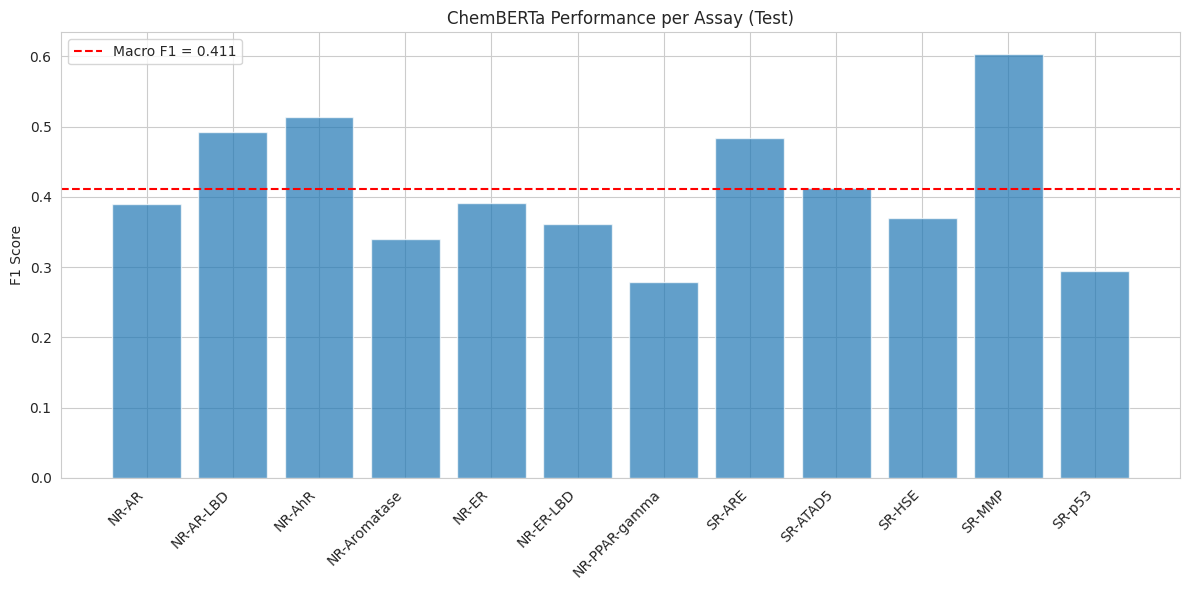

In [ ]:
import matplotlib.pyplot as plt

tasks = list(per_task_metrics.keys())
f1s = [per_task_metrics[t]["f1"] for t in tasks]

plt.figure(figsize=(12,6))
plt.bar(range(len(tasks)), f1s, alpha=0.7)
plt.axhline(macro_f1, color="red", linestyle="--", label=f"Macro F1 = {macro_f1:.3f}")
plt.xticks(range(len(tasks)), tasks, rotation=45, ha="right")
plt.ylabel("F1 Score")
plt.title("ChemBERTa Performance per Assay (Test)")
plt.legend()
plt.tight_layout()
plt.savefig("results/figures/chemberta_performance.png", dpi=150)
plt.show()


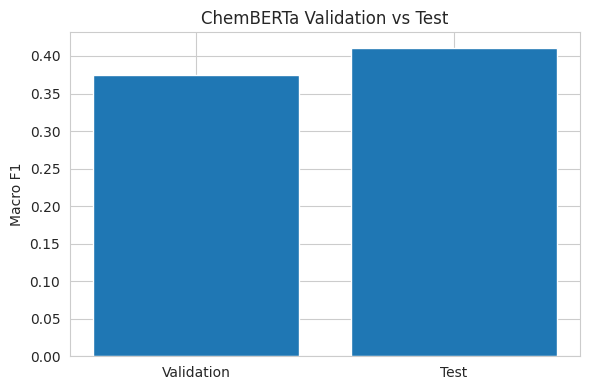

In [ ]:
plt.figure(figsize=(6,4))
plt.bar(["Validation", "Test"], [trainer.best_val_f1, macro_f1])
plt.ylabel("Macro F1")
plt.title("ChemBERTa Validation vs Test")
plt.tight_layout()
plt.savefig("results/figures/chemberta_val_vs_test.png", dpi=150)
plt.show()


In [ ]:

out_dir = Path("models/chemberta_final")
out_dir.mkdir(parents=True, exist_ok=True)

torch.save(
    trainer.model.state_dict(),
    out_dir / "model_state_dict.pt"
)

print("Saved: model_state_dict.pt")


Saved: model_state_dict.pt
